In [24]:
import anuga
import numpy as np
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2
%matplotlib inline

# Allow inline jshtml animations
from matplotlib import rc
rc('animation', html='jshtml')

lat_ll, lon_ll = -34.2, 150.5
lat_ur, lon_ur = -33.2, 151.5

crop = 0.05

In [2]:
# Download elevation data for Sydney area
import elevation
import os
cwd = os.getcwd()

tif_filename = anuga.join(cwd,r'Sydney-DEM.tif')




In [3]:
if not os.path.exists(tif_filename):
    elevation.clip(bounds=(lon_ll-crop, lat_ll-crop, lon_ur+crop, lat_ur+crop), 
                   output=tif_filename)
    elevation.clean()

/home/steve/miniforge3/envs/anuga_env_39/lib/python3.9/site-packages/osgeo/gdal.py:312: FutureWarning: Neither gdal.UseExceptions() nor gdal.DontUseExceptions() has been explicitly called. In GDAL 4.0, exceptions will be enabled by default.
  warnings.warn(


3960 3960
-32768.0


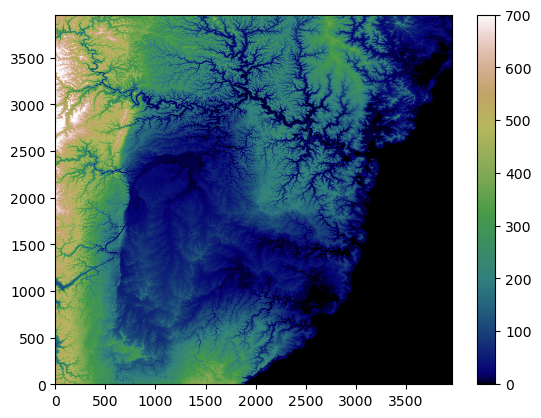

In [4]:
from osgeo import gdal

dataset = gdal.Open(r'Sydney-DEM.tif')
#print(dataset.RasterCount)
print(dataset.RasterXSize, dataset.RasterYSize)

band1 = dataset.GetRasterBand(1)
novalue = band1.GetNoDataValue()

print(novalue)

b1 = band1.ReadAsArray()

b1 = np.flipud(b1)

#plt.figure(figsize=(10,10))
ax = plt.axes()
plt.pcolormesh(b1, cmap='gist_earth', vmin=-1.0, vmax=700)
plt.colorbar()
plt.show()

In [5]:
def zone_letter_to_hemisphere(zone_letter):
    hemisphere = 'undefined'
    if zone_letter.lower() in 'cdefghjklm':
        hemisphere = 'southern'
    if zone_letter.lower() in 'npqrstuvwx':
        hemisphere = 'northern'
        
    return hemisphere

import utm

utm_east_ll, utm_north_ll, zone_ll, zone_dd_ll = utm.from_latlon(lat_ll, lon_ll)
utm_east_ur, utm_north_ur, zone_ur, zone_dd_ur = utm.from_latlon(lat_ur, lon_ur)

hemi_ll = zone_letter_to_hemisphere(zone_dd_ll)
hemi_ur = zone_letter_to_hemisphere(zone_dd_ll)


print(utm_east_ll, utm_north_ll, zone_ll, zone_dd_ll, hemi_ll)
print(utm_east_ur, utm_north_ur, zone_ur, zone_dd_ur, hemi_ur)

utm_east_len = utm_east_ur - utm_east_ll
utm_north_len = utm_north_ur - utm_north_ll

utm_origin = (utm_east_ll, utm_north_ll)

print(utm_east_len, utm_north_len)

269645.77398930304 6212842.207926389 56 H southern
360186.80045065586 6325538.419045925 56 H southern
90541.02646135283 112696.21111953631


In [6]:
domain = anuga.rectangular_cross_domain(200,200,
                               len1=utm_east_len,
                               len2=utm_north_len,
                               origin=utm_origin)
domain.set_zone(zone_ll)
domain.set_hemisphere(hemi_ll)

dplotter = anuga.Domain_plotter(domain) # should set this up via a set_plotter command

Br = anuga.Reflective_boundary(domain)
domain.set_boundary({'left': Br, 'right': Br, 'top': Br, 'bottom': Br})

# Put some rain on the domain
anuga.Rate_operator(domain, rate=0.1);


region = anuga.Region(domain, center=[utm_east_ll+utm_east_len/2, utm_north_ll+utm_north_len/2], radius=100000)


# Use tif file to set elevation
domain.set_quantity('elevation', 
                    filename = r'Sydney-DEM.tif', 
                    indices = region.indices,
                    location='centroids')

domain.set_quantity('friction', 0.01)

# Note that quantities (in particular stage) have a default value of zero

Figure files for each frame will be stored in _plot


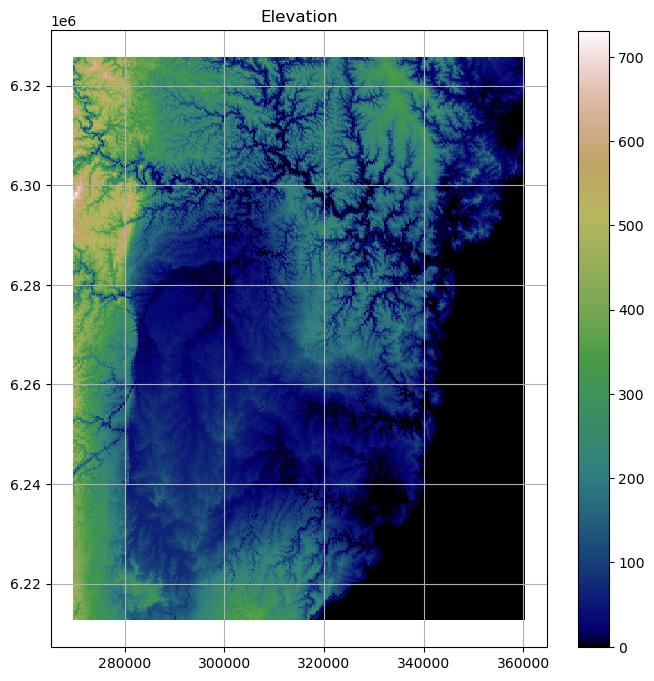

In [7]:
#plt.figure(figsize=(10,16))

fig, ax = plt.subplots(figsize=(8,10))

ax.set_aspect('equal')

tpc = ax.tripcolor(dplotter.triang,
              facecolors = dplotter.elev,
              cmap='gist_earth',
              vmin = 0.0)


fig.colorbar(tpc, shrink=0.8)
ax.grid(True)
#ax.axis('off')
#ax.set_xticks([])
#ax.set_yticks([])
ax.set_title("Elevation");

In [8]:
for t in domain.evolve(yieldstep=300, finaltime=1200):
    domain.print_timestepping_statistics()

Time = 0.0000 (sec), steps=0 (25s)
Time = 300.0000 (sec), delta t in [1.12470883, 1.17295293] (s), steps=262 (16s)
Time = 600.0000 (sec), delta t in [0.96316367, 1.12466238] (s), steps=281 (16s)
Time = 900.0000 (sec), delta t in [0.89083129, 0.96309332] (s), steps=324 (19s)
Time = 1200.0000 (sec), delta t in [0.80888546, 0.89079634] (s), steps=359 (21s)


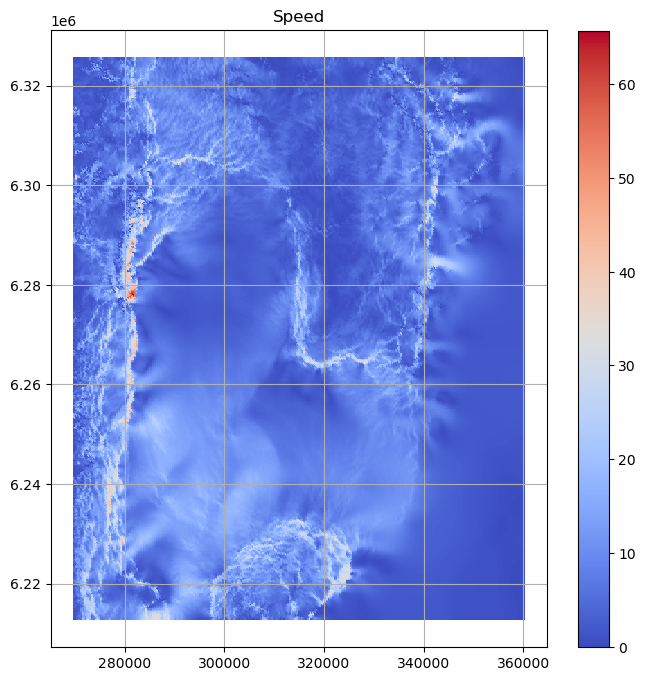

In [9]:
depth = dplotter.stage - dplotter.elev 
speed = np.sqrt(dplotter.xmom**2 + dplotter.ymom**2 ) / depth


fig, ax = plt.subplots(figsize=(8,10))
ax.set_aspect('equal')

tpc = ax.tripcolor(dplotter.triang,
              facecolors = speed,
              cmap='coolwarm',
              vmin = 0.0)


fig.colorbar(tpc, shrink=0.8)
ax.grid(True)
ax.set_title("Speed");




In [27]:
splotter = anuga.SWW_plotter('domain.sww')

from anuga.utilities.plot_utils import Make_Geotif

Make_Geotif('domain.sww',['depth'], myTimeStep='max', CellSize=1000.0, EPSG_CODE=28356, verbose=True)


Figure files for each frame will be stored in _plot
Reading sww File ...
Extracting required data ...
Computing grid of output locations...
Making interpolation functions...
Reduction =  max
output_quantity depth
Making raster ...


In [38]:
cd TIFS

/home/steve/anuga_jupyter_notebooks/TIFS


In [40]:
view_tif(r'domain_max_depth.tif')


ERROR 4: domain_max_depth.tif: No such file or directory


AttributeError: 'NoneType' object has no attribute 'RasterCount'

In [41]:
def view_tif(filename):
    dataset = gdal.Open(filename)
    print(dataset.RasterCount)
    print(dataset.RasterXSize, dataset.RasterYSize)

    band1 = dataset.GetRasterBand(1)
    novalue = band1.GetNoDataValue()

    print(novalue)

    b1 = band1.ReadAsArray()

    b1 = np.flipud(b1)

    dataset = None

    #plt.figure(figsize=(10,10))
    ax = plt.axes()
    plt.pcolormesh(b1, cmap='gist_earth', vmin=-1.0, vmax=700)
    plt.colorbar()
    plt.show()


view_tif(r'domain_depth_max.tif')


1
91 114
nan


AttributeError: module 'osgeo.gdal' has no attribute 'Close'